<img src="images/dqn.jpg" align=right width=25%>
# Deep Q-Learning
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Configuration](#Configuration)
- [Replay memory](#Replay-memory)
- [Deep Q-network](#Deep-Q-network)
- [Environment](#Environment)

This notebook is PyTorch implementation of Deep Q-Learning based on [this tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

In [10]:
from collections import namedtuple

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import gym
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchsummary import summary
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from IPython import display

## Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## Environment

In [11]:
def render(env, t):
    display.clear_output(wait=True)
    plt.figure()
    plt.clf()
    plt.axis("off")
    plt.title(f"t = {t}")
    plt.imshow(env.render(mode='rgb_array'))
    plt.pause(0.001)

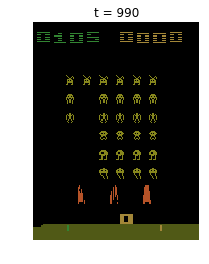

In [15]:
env = wrap_deepmind(make_atari("SpaceInvadersNoFrameskip-v4"))
obs = env.reset()
for t in range(1000):
    if t % 10 == 0:
        render(env, t)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

## Replay memory

In [3]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

In [4]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self._capacity = capacity
        self._memory = []
        self._position = 0
        
    def __len__(self):
        return len(self._memory)
        
    def push(self, *args):
        if len(self._memory) < self._capacity:
            self._memory.append(None) # make room for later
        self._memory[self._position] = Transition(*args)
        # if the memory is full, start pushing the beginning
        self._position = (self._position + 1) % self._capacity
        
    def sample(self, batch_size):
        return random.sample(self._memory, batch_size)

## Deep Q-network

Here, we're going to build the Q-network, based on the original architecture used in [DeepMind's Nature article](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

In [5]:
class NatureDQN(nn.Module):
    def __init__(self, in_channels=4, act_dim=18):
        super(NatureDQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, act_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc4(x))
        return self.fc5(x)

In [6]:
model = NatureDQN().to(device)
summary(model, (4, 84, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                   [-1, 18]           9,234
Total params: 1,693,362
Trainable params: 1,693,362
Non-trainable params: 0
----------------------------------------------------------------
